# 导师制名企实训班商业智能方向 004期 Lesson 10

### Action 1: 智能供应链分析
数据集：SupplyChainDataset.csv，供应链采购数据  
To Do：  
对于欺诈订单进行预测，即Order Status='SUSPECTED_FRAUD'  
对于迟交货订单进行预测，即Delivery Status= 'Late delivery'  
对于销售额进行预测，即Sales字段  
对于订货数量进行预测，即Order Item Quantity  

In [1]:
# 引包
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # 忽略版本问题

In [2]:
# 数据加载
data = pd.read_csv('data/SupplyChain.csv', encoding='unicode_escape')
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
# 将firstname 与 lasename合并
data['Customer Full Name'] = data['Customer Fname'] + data['Customer Lname']
data[['Customer Full Name', 'Customer Fname', 'Customer Lname']]

,Customer Full Name,Customer Fname,Customer Lname
0,CallyHolloway,Cally,Holloway
1,IreneLuna,Irene,Luna
2,GillianMaldonado,Gillian,Maldonado
3,TanaTate,Tana,Tate
4,OrliHendricks,Orli,Hendricks
...,...,...,...
180514,MariaPeterson,Maria,Peterson
180515,RonaldClark,Ronald,Clark
180516,JohnSmith,John,Smith
180517,MarySmith,Mary,Smith


In [4]:
# 空值用0进行填充
data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)

### RFM分析

In [5]:
# 创建时间戳索引
temp = pd.DatetimeIndex(data['order date (DateOrders)'])

In [6]:
# 'order date (DateOrders)' 字段中的year，month，weekday，hour，month_year
data['order_year'] = temp.year
data['order_month'] = temp.month
data['order_week_day'] = temp.weekday
data['order_hour'] = temp.hour
data['order_month_year'] = temp.to_period('M')
data[['order_year', 'order_month', 'order_week_day', 'order_hour', 'order_month_year']]

,order_year,order_month,order_week_day,order_hour,order_month_year
0,2018,1,2,22,2018-01
1,2018,1,5,12,2018-01
2,2018,1,5,12,2018-01
3,2018,1,5,11,2018-01
4,2018,1,5,11,2018-01
...,...,...,...,...,...
180514,2016,1,5,3,2016-01
180515,2016,1,5,1,2016-01
180516,2016,1,4,21,2016-01
180517,2016,1,4,20,2016-01


In [7]:
# 时间类型转换
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])
# 统计最后一笔订单时间
data['order date (DateOrders)'].max()

Timestamp('2018-01-31 23:38:00')

In [8]:
# 假设当前时间 2018-2-1
import datetime
present = datetime.datetime(2018, 2, 1)
present

datetime.datetime(2018, 2, 1, 0, 0)

In [9]:
# 计算每个用户的RFM指标
# 按照Order Customer Id 进行聚合 Recency, Frequency, Money
customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x:(present-x.max()).days, \
                                                     'Order Id': lambda x:len(x), \
                                                     'Sales': lambda x:x.sum()})
customer_seg

,order date (DateOrders),Order Id,Sales
Order Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [10]:
# 转换为 [1,4]
# R_Value越小越好 -> R_Score越大
def R_Score(a, b, c):
    if a <= c[b][0.25]:
        return 4
    if a <= c[b][0.5]:
        return 3
    if a <= c[b][0.75]:
        return 2
    return 1
# Frequency, Money
def FM_Score(a, b, c):
    if a <= c[b][0.25]:
        return 1
    if a <= c[b][0.5]:
        return 2
    if a <= c[b][0.75]:
        return 3
    return 4

In [11]:
# 将字段名称改为 R_Value, F_Value, M_Value
customer_seg.rename(columns = {'order date (DateOrders)':'R_Value', \
                              'Order Id': 'F_Value', \
                              'Sales':'M_Value'}, inplace=True)
customer_seg

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [12]:
# 将RFM数据划分为4个尺度
quantiles = customer_seg.quantile(q=[0.25, 0.5, 0.75])
quantiles

,R_Value,F_Value,M_Value
0.25,75.0,1.0,293.040008
0.50,159.0,7.0,1499.825033
0.75,307.0,15.0,2915.880065


In [13]:
quantiles = quantiles.to_dict()
quantiles

{'R_Value': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0},
 'F_Value': {0.25: 1.0, 0.5: 7.0, 0.75: 15.0},
 'M_Value': {0.25: 293.0400085, 0.5: 1499.82503324, 0.75: 2915.8800654175}}

In [14]:
# 新建R_Score， 用于将R_Value -> [1,4]
customer_seg['R_Score'] = customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
customer_seg['F_Score'] = customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
customer_seg['M_Score'] = customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,499.950012,1,1,2
2,136,10,1819.730034,3,3,3
3,229,18,3537.680094,2,4,4
4,380,14,1719.630030,1,3,3
5,457,7,1274.750023,1,2,2
...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1
20754,0,1,215.820007,4,1,1
20755,0,1,327.750000,4,1,2


In [15]:
# 计算RFM用户分层
def RFM_User(df):
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '重要价值用户'
    if df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '重要发展用户'
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '重要保持用户'
    if df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '重要挽留用户'
    if df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '一般价值用户'
    if df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '一般发展用户'
    if df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '一般保持用户'
    if df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '一般挽留用户'

In [16]:
customer_seg['Customer_Segmentation'] = customer_seg.apply(RFM_User, axis=1)
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Customer_Segmentation
Order Customer Id,,,,,,,
1,792,1,499.950012,1,1,2,一般挽留用户
2,136,10,1819.730034,3,3,3,重要价值用户
3,229,18,3537.680094,2,4,4,重要保持用户
4,380,14,1719.630030,1,3,3,重要保持用户
5,457,7,1274.750023,1,2,2,一般挽留用户
...,...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1,一般发展用户
20754,0,1,215.820007,4,1,1,一般发展用户
20755,0,1,327.750000,4,1,2,一般发展用户


In [17]:
# 显示不用地区的支付类型情况
data['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [18]:
pay_type1 = data[data['Type'] == 'DEBIT']
pay_type2 = data[data['Type'] == 'TRANSFER']
pay_type3 = data[data['Type'] == 'PAYMENT']
pay_type4 = data[data['Type'] == 'CASH']

In [19]:
# 获取4种支付方式中，不同地区的特点
count1 = pay_type1['Order Region'].value_counts()
count2 = pay_type2['Order Region'].value_counts()
count3 = pay_type3['Order Region'].value_counts()
count4 = pay_type4['Order Region'].value_counts()
print('\nDEBIT:\n', count1,'\nTRANSFER:\n', count2, '\nPAYMENT:\n',count3,'\nCASH:\n',count4)


DEBIT:
 Central America    10804
Western Europe     10362
South America       5536
Oceania             3985
Northern Europe     3807
Southern Europe     3656
Southeast Asia      3567
West of USA         3187
Caribbean           3101
South Asia          3009
East of USA         2776
Eastern Asia        2634
US Center           2317
West Asia           2306
Eastern Europe      1577
South of  USA       1525
West Africa         1502
North Africa        1235
East Africa          737
Central Africa       659
Southern Africa      485
Canada               311
Central Asia         217
Name: Order Region, dtype: int64 
TRANSFER:
 Central America    8047
Western Europe     7457
South America      4236
Northern Europe    2645
Oceania            2644
Southeast Asia     2622
Southern Europe    2540
Caribbean          2424
West of USA        2249
South Asia         2097
Eastern Asia       2058
East of USA        1818
West Asia          1636
US Center          1581
South of  USA      1142
Eastern Eur

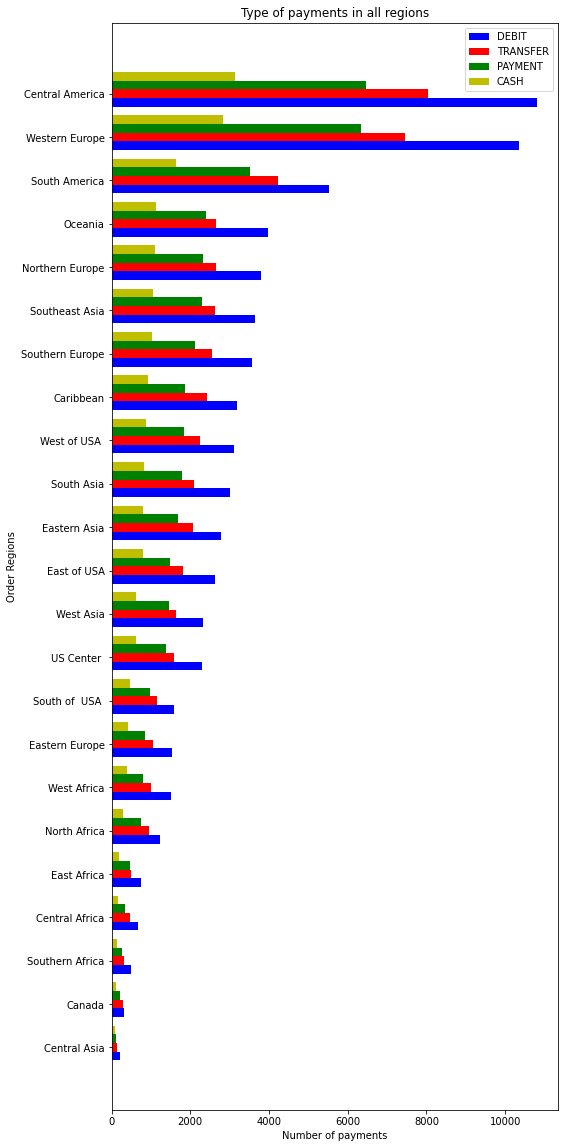

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# 获取地区region的个数
region_num = len(count1)
fig, ax = plt.subplots(figsize=(8,20))
index = np.arange(region_num)
# 每种类型的显示间隔
bar_width = 0.2
type1 = plt.barh(index, count1[::-1], bar_width, color='b', label='DEBIT')
type2 = plt.barh(index+bar_width, count2[::-1], bar_width, color='r', label='TRANSFER')
type3 = plt.barh(index+bar_width*2, count3[::-1], bar_width, color='g', label='PAYMENT')
type4 = plt.barh(index+bar_width*3, count4[::-1], bar_width, color='y', label='CASH')
plt.ylabel('Order Regions')
plt.xlabel('Number of payments')
plt.title('Type of payments in all regions')
plt.legend()
# 显示刻度
names = data['Order Region'].value_counts().keys()
plt.yticks(index+bar_width, names[::-1])
plt.show()

### 分析结论
DEBIT(借记)是所有地区中使用最多的支付方式
CASH(现金)是所有地区中使用最少的支付方式
所有地区的四种支付方式大体一致

### 欺诈订单分析

<AxesSubplot:title={'center':'Products with most loss'}>

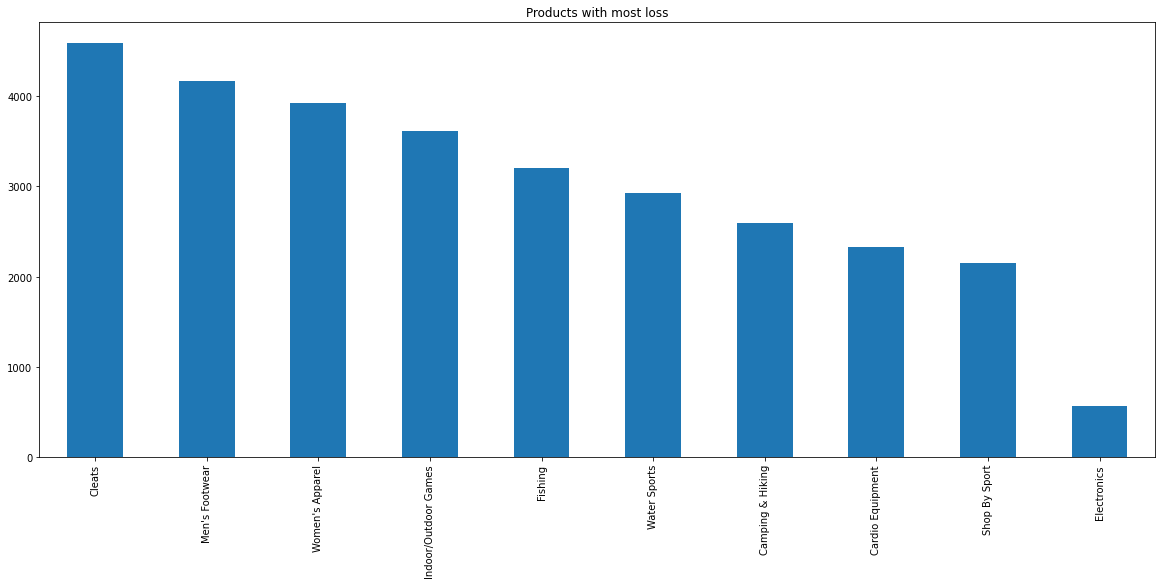

In [21]:
# 对负收益产品进行探索
loss = data[data['Benefit per order'] < 0]
# 显示Top10负收益产品
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Products with most loss')

<AxesSubplot:title={'center':'Regions with most loss'}>

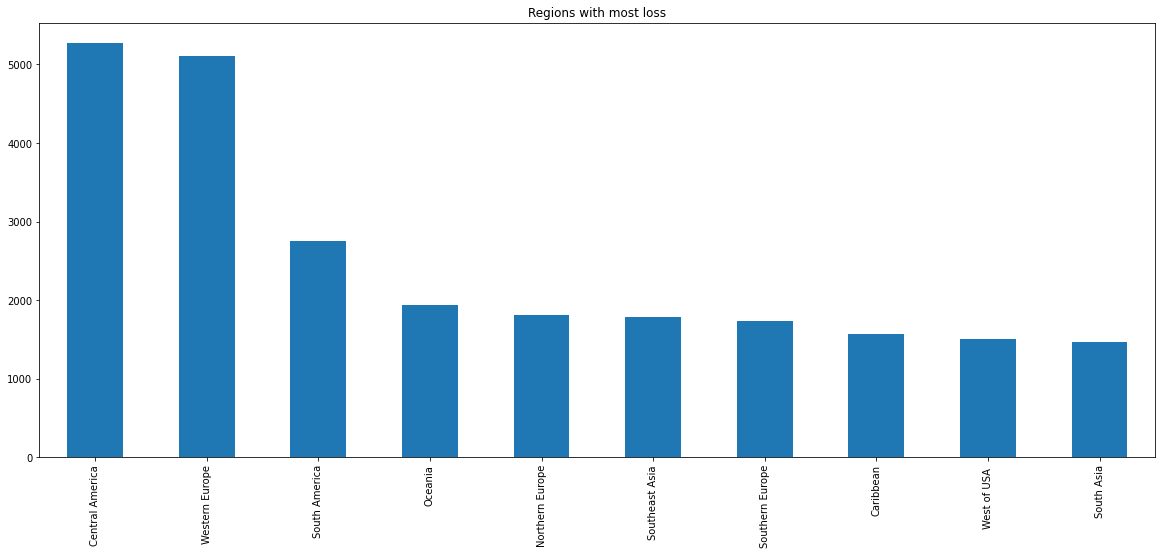

In [22]:
# 显示Top10的负收益地区
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Regions with most loss')

In [23]:
# 所有负收益产品带来的损失
print('总损失', loss['Benefit per order'].sum())

总损失 -3883547.345768667


In [24]:
data['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

In [25]:
# 负收益，可能是欺诈交易，来自于那种方式
data[data['Order Status']=='SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    4062
Name: Type, dtype: int64

### TRANSFER 容易导致欺诈交易

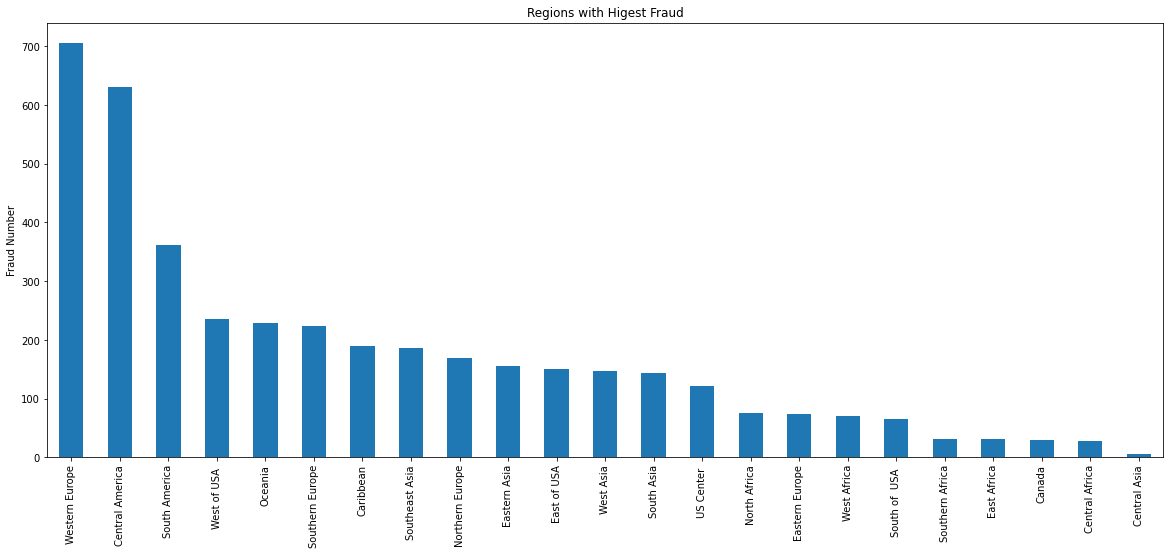

In [26]:
# 显示不同地区的欺诈交易情况
high_fraud = data[data['Order Status'] == 'SUSPECTED_FRAUD']
high_fraud['Order Region'].value_counts().plot.bar(figsize=(20,8), title='Regions with Higest Fraud')
plt.ylabel('Fraud Number')
plt.show()

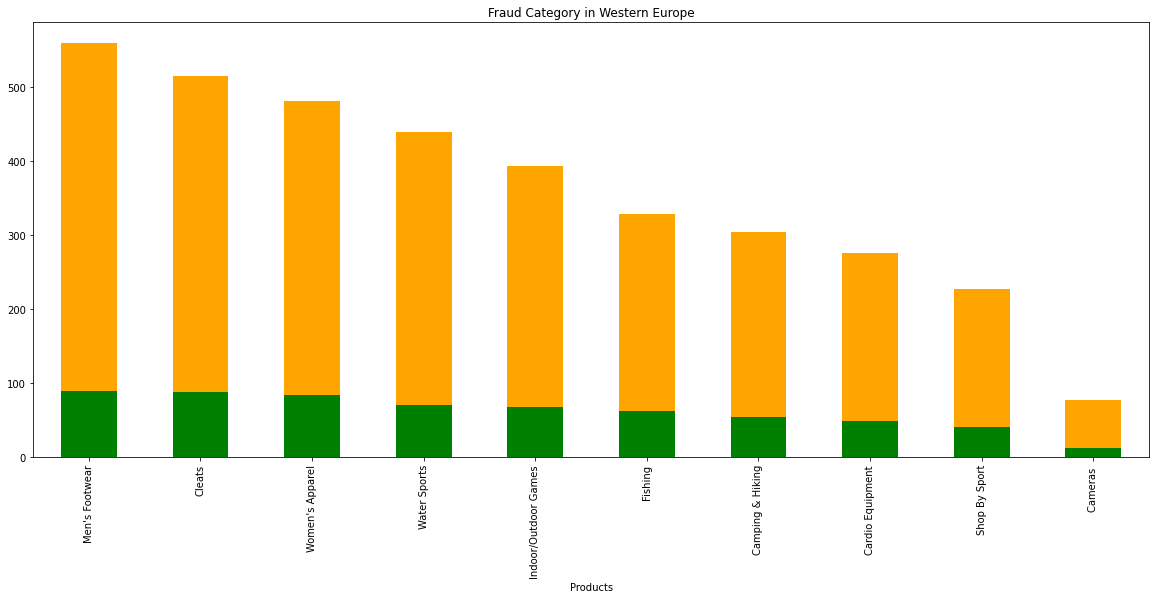

In [27]:
# Western Europe地区欺诈交易最多，将一个bar分成2个部分（堆积条形图）
high_fraud_total = data[data['Order Status']=='SUSPECTED_FRAUD']
high_fraud_we = data[(data['Order Status']=='SUSPECTED_FRAUD') & (data['Order Region']=='Western Europe')]
# 找出风险最高的10个Category
fraud1 = high_fraud_total['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Fraud Category', color='orange')
fraud2 = high_fraud_we['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Fraud Category in Western Europe', color='green')
plt.xlabel('Products')
plt.show()

<AxesSubplot:title={'center':'Top10 Highest Fraud Customers'}>

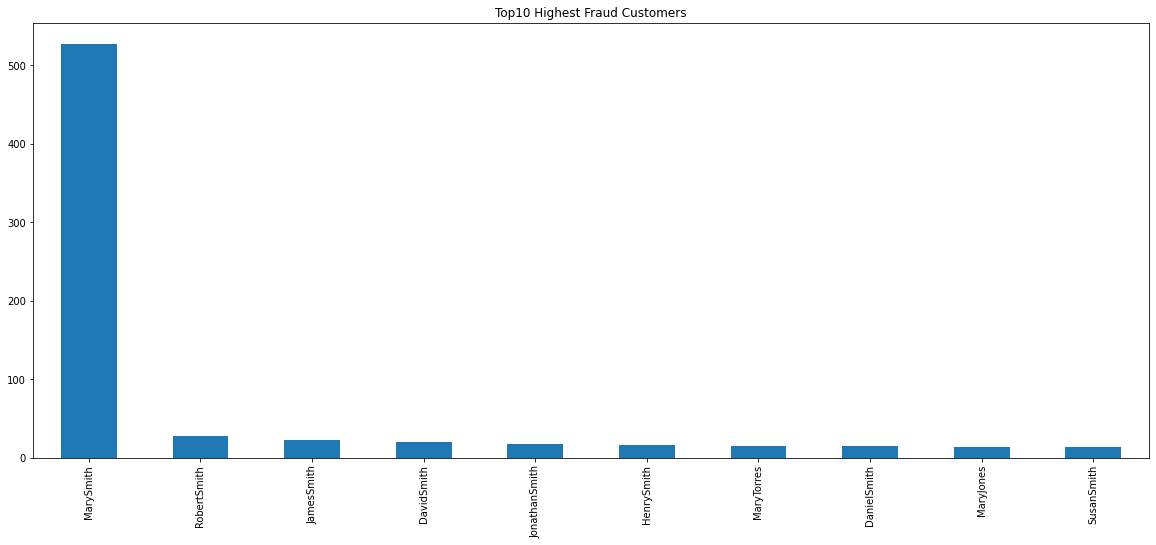

In [28]:
# 筛选出Top10 Customer（风险）
cus = data[data['Order Status'] == 'SUSPECTED_FRAUD']
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Top10 Highest Fraud Customers')

In [29]:
# 找到MarySmith的交易金额
print(data[data['Customer Full Name'] == 'MarySmith']['Sales'].sum())
print(data[(data['Customer Full Name'] == 'MarySmith') & (data['Order Status'] == 'SUSPECTED_FRAUD')]['Sales'].sum())

4771645.883297398
102491.66191043999


In [30]:
import pickle
with open('data/data.pkl', 'wb') as file:
    pickle.dump(data, file)

### 预测

In [31]:
with open('data/data.pkl', 'rb') as file:
    train_data = pickle.load(file)
train_data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,order_month_year
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,327.750000,0,2/3/2018 22:56,Standard Class,CallyHolloway,2018,1,2,22,2018-01
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,327.750000,0,1/18/2018 12:27,Standard Class,IreneLuna,2018,1,5,12,2018-01
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,327.750000,0,1/17/2018 12:06,Standard Class,GillianMaldonado,2018,1,5,12,2018-01
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,327.750000,0,1/16/2018 11:45,Standard Class,TanaTate,2018,1,5,11,2018-01
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,327.750000,0,1/15/2018 11:24,Standard Class,OrliHendricks,2018,1,5,11,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,399.980011,0,1/20/2016 3:40,Standard Class,MariaPeterson,2016,1,5,3,2016-01
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,399.980011,0,1/19/2016 1:34,Second Class,RonaldClark,2016,1,5,1,2016-01
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,399.980011,0,1/20/2016 21:00,Standard Class,JohnSmith,2016,1,4,21,2016-01
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,399.980011,0,1/18/2016 20:18,Standard Class,MarySmith,2016,1,4,20,2016-01


构造人工特征

In [32]:
train_data['fraud'] = np.where(train_data['Order Status']=='SUSPECTED_FRAUD', 1, 0)
train_data['fraud']

0         0
1         0
2         0
3         0
4         0
         ..
180514    0
180515    0
180516    0
180517    0
180518    0
Name: fraud, Length: 180519, dtype: int64

In [33]:
train_data['late_delivery'] = np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)
train_data['late_delivery']

0         0
1         1
2         0
3         0
4         0
         ..
180514    0
180515    1
180516    1
180517    0
180518    0
Name: late_delivery, Length: 180519, dtype: int64

In [34]:
categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols

Index(['Type', 'Delivery Status', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Region', 'Order State',
       'Order Status', 'Product Image', 'Product Name',
       'shipping date (DateOrders)', 'Shipping Mode', 'Customer Full Name'],
      dtype='object')

In [35]:
train_data['order date (DateOrders)'] = pd.to_datetime(train_data['order date (DateOrders)'], format='%d-%m-%Y %H:%M')
min_date = train_data['order date (DateOrders)'].min()
train_data['days_diff'] = (train_data['order date (DateOrders)'] - min_date).dt.days
train_data['days_diff']

0         1126
1         1108
2         1108
3         1108
4         1108
          ... 
180514     380
180515     380
180516     379
180517     379
180518     379
Name: days_diff, Length: 180519, dtype: int64

In [36]:
train_data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [37]:
train_data.drop(['Customer Email', 'Customer Password', 'Product Description', \
                 'Product Status', 'Product Image', 'Customer Fname',  \
                 'Customer Lname', 'Order Customer Id', 'Order Item Cardprod Id', \
                 'Order Item Id', 'Sales per customer', 'Order Item Total', \
                 'Order Profit Per Order', 'Product Card Id', \
                 'Product Category Id', 'Product Price', 'Order Zipcode', \
                 'order date (DateOrders)', 'Latitude', 'Longitude', \
                 'Customer Street', 'order_month_year', 'Order Status', \
                 'Delivery Status', 'Late_delivery_risk'], axis=1, inplace=True)
len(train_data.columns)

37

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Category Id                    180519 non-null  int64  
 5   Category Name                  180519 non-null  object 
 6   Customer City                  180519 non-null  object 
 7   Customer Country               180519 non-null  object 
 8   Customer Id                    180519 non-null  int64  
 9   Customer Segment               180519 non-null  object 
 10  Customer State                 180519 non-null  object 
 11  Customer Zipcode               180519 non-null  float64
 12  Department Id                 

In [39]:
# 查看分类类型
categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols

Index(['Type', 'Category Name', 'Customer City', 'Customer Country',
       'Customer Segment', 'Customer State', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Region', 'Order State',
       'Product Name', 'shipping date (DateOrders)', 'Shipping Mode',
       'Customer Full Name'],
      dtype='object')

In [40]:
train_data = train_data.dropna(subset=['Customer Full Name'])

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat in categorical_cols:
    train_data[cat] = le.fit_transform(train_data[cat])
train_data[categorical_cols]

,Type,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Market,Order City,Order Country,Order Region,Order State,Product Name,shipping date (DateOrders),Shipping Mode,Customer Full Name
0,1,40,66,1,0,36,4,3,331,70,15,475,78,27142,3,1875
1,3,40,66,1,0,36,4,3,391,69,13,841,78,2208,3,5374
2,0,40,452,0,0,5,4,3,391,69,13,841,78,1979,3,4426
3,1,40,285,0,2,5,4,3,3226,8,11,835,78,1751,3,12922
4,2,40,66,1,1,36,4,3,3226,8,11,835,78,1527,3,10632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,0,18,59,0,2,31,3,3,2922,31,7,913,24,2732,3,8421
180515,1,18,26,0,1,5,3,3,1362,77,7,770,24,2338,2,11672
180516,3,18,55,0,1,7,3,3,25,8,11,88,24,2726,3,6296
180517,2,18,66,1,0,36,3,3,25,8,11,88,24,2113,3,9379


In [42]:
# 得到所有数值类型
numerical_columns = train_data.columns.tolist()
for x in categorical_cols.tolist():
    numerical_columns.remove(x)
numerical_columns

['Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Category Id',
 'Customer Id',
 'Customer Zipcode',
 'Department Id',
 'Order Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'order_year',
 'order_month',
 'order_week_day',
 'order_hour',
 'fraud',
 'late_delivery',
 'days_diff']

### 分类任务预测
对于欺诈订单进行预测，即Order Status='SUSPECTED_FRAUD'   
对于迟交货订单进行预测，即Delivery Status= 'Late delivery'

In [43]:
train_data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Region', 'Order State', 'Product Name',
       'shipping date (DateOrders)', 'Shipping Mode', 'Customer Full Name',
       'order_year', 'order_month', 'order_week_day', 'order_hour', 'fraud',
       'late_delivery', 'days_diff'],
      dtype='object')

In [44]:
# fraud数据集
x_fraud = train_data.loc[:, train_data.columns!='fraud']
y_fraud = train_data.loc[:, 'fraud']
# late数据集
x_late = train_data.loc[:,  train_data.columns!='late_delivery']
y_late = train_data.loc[:, 'late_delivery']

In [45]:
from sklearn.model_selection import train_test_split
# fraud数据集切分
x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test = train_test_split(x_fraud, y_fraud, test_size=0.2)
# late数据集切分
x_late_train, x_late_test, y_late_train, y_late_test = train_test_split(x_late, y_late, test_size=0.2)

In [46]:
pd.set_option('display.max_columns', None)
x_fraud_train

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Category Id,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Department Id,Department Name,Market,Order City,Order Country,Order Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order State,Product Name,shipping date (DateOrders),Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,late_delivery,days_diff
90819,2,5,4,5.800000,5,32,66,1,8479,1,36,725.0,2,4,2,1958,105,9044,5.00,0.20,24.990000,0.29,1,24.990000,3,616,106,39860,3,13579,2015,5,2,0,1,132
31371,3,3,4,-173.169998,24,47,66,1,4263,2,36,725.0,5,6,3,187,77,22442,13.75,0.06,50.000000,-0.73,5,250.000000,7,428,59,15826,3,10800,2015,11,1,14,0,327
69675,2,6,4,53.200001,24,47,461,0,4986,1,5,92707.0,5,6,2,1344,102,51315,10.00,0.05,50.000000,0.28,4,200.000000,3,937,59,3961,3,6912,2017,1,3,1,1,749
155768,2,3,4,46.200001,24,47,66,1,1554,0,36,725.0,5,6,2,3199,20,4132,30.00,0.12,50.000000,0.21,5,250.000000,12,787,59,32623,3,4702,2015,3,0,7,0,60
135297,3,5,4,9.040000,24,47,148,0,1902,0,32,44035.0,5,6,1,1032,53,62169,20.00,0.20,50.000000,0.11,2,100.000000,22,731,59,48489,3,346,2017,6,0,12,1,907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,1,3,2,69.070000,70,33,66,1,16050,0,36,725.0,4,0,3,516,8,72497,18.98,0.09,210.850006,0.36,1,210.850006,11,835,48,15979,2,10442,2017,11,4,6,1,1058
71855,3,2,2,8.740000,18,34,427,0,10363,1,5,92509.0,4,0,1,1046,120,65146,5.20,0.04,129.990005,0.07,1,129.990005,10,454,56,53857,2,2353,2017,8,1,23,0,950
58637,2,2,1,24.700001,18,34,66,1,5793,0,36,725.0,4,0,2,3139,66,33,6.50,0.05,129.990005,0.20,1,129.990005,3,346,56,4998,0,8381,2015,1,3,11,1,0
99415,2,2,4,47.130001,46,30,66,1,6569,0,36,725.0,7,3,4,2469,48,40296,10.50,0.07,49.980000,0.34,3,149.940002,6,796,67,54332,3,11934,2016,8,3,5,0,588


In [47]:
from sklearn.preprocessing import StandardScaler
# 数据规范化
sc = StandardScaler()
# fraud
x_fraud_train = sc.fit_transform(x_fraud_train)
x_fraud_test = sc.transform(x_fraud_test)
# late
x_late_train = sc.fit_transform(x_late_train)
x_late_test = sc.transform(x_late_test)

In [48]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, f1_score
def model_stats(model, x_train, x_test, y_train, y_test, name='Fraud'):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    auc = roc_auc_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    confusion = confusion_matrix(y_pred, y_test)
    print('Model Used:', model)
    print('{} Accuracy: {}%'.format(name, accuracy*100))
    print('{} Recall: {}%'.format(name, recall*100))
    print('{} AUC: {}%'.format(name, auc*100))
    print('{} F1 Score: {}%'.format(name, f1*100))
    print('{} Confusion Matrix:\n {}'.format(name, confusion))
    return model, accuracy, recall, f1

In [49]:
from sklearn.linear_model import LogisticRegression
# 逻辑回归模型
# fraud
model_fraud = LogisticRegression()
print(model_stats(model_fraud, x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test, 'Fraud'))
# late
model_late = LogisticRegression()
print(model_stats(model_late, x_late_train, x_late_test, y_late_train, y_late_test, 'Late Delivery'))

Model Used: LogisticRegression()
Fraud Accuracy: 97.77580810458964%
Fraud Recall: 48.23529411764706%
Fraud AUC: 73.24104274710473%
Fraud F1 Score: 29.00088417329797%
Fraud Confusion Matrix:
 [[35136   627]
 [  176   164]]
(LogisticRegression(), 0.9777580810458965, 0.4823529411764706, 0.2900088417329797)
Model Used: LogisticRegression()
Late Delivery Accuracy: 98.81450294989335%
Late Delivery Recall: 97.88359788359789%
Late Delivery AUC: 98.94179894179894%
Late Delivery F1 Score: 98.93048128342245%
Late Delivery Confusion Matrix:
 [[15880     0]
 [  428 19795]]
(LogisticRegression(), 0.9881450294989336, 0.9788359788359788, 0.9893048128342246)


### 回归任务预测
对于销售额进行预测，即Sales字段  
对于订货数量进行预测，即Order Item Quantity  

In [50]:
# sales数据集
x_sales = train_data.loc[:,  train_data.columns!='Sales']
y_sales = train_data.loc[:, 'Sales']
# OIQ数据集
x_oiq = train_data.loc[:,  train_data.columns!='Order Item Quantity']
y_oiq = train_data.loc[:, 'Order Item Quantity']

In [51]:
# sqles数据集切分
x_sales_train, x_sales_test, y_sales_train, y_sales_test = train_test_split(x_sales, y_sales, test_size=0.2)
# OIQ数据集切分
x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test = train_test_split(x_oiq, y_oiq, test_size=0.2)

In [52]:
# sales
x_sales_train = sc.fit_transform(x_sales_train)
x_sales_test = sc.transform(x_sales_test)
# OIQ
x_oiq_train = sc.fit_transform(x_oiq_train)
x_oiq_test = sc.transform(x_oiq_test)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def model_stats_r(model, x_train, x_test, y_train, y_test, name='Sales'):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    print('Model Used:', model)
    print('{} MAE: {}'.format(name, mae))
    print('{} MSE: {}'.format(name, mse))
    print('{} R2 Score: {}'.format(name, r2))
    return model, mae, mse, r2

In [55]:
from sklearn.linear_model import LinearRegression
# 线性回归模型
# sales
model_sales = LinearRegression()
print(model_stats_r(model_sales, x_sales_train, x_sales_test, y_sales_train, y_sales_test, 'Sales'))
# OIQ
model_oiq = LinearRegression()
print(model_stats_r(model_oiq, x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test, 'Order Item Quantity'))

Model Used: LinearRegression()
Sales MAE: 18.411933144172945
Sales MSE: 957.8300418423652
Sales R2 Score: 0.9416032086917814
(LinearRegression(), 18.411933144172945, 957.8300418423652, 0.9416032086917814)
Model Used: LinearRegression()
Order Item Quantity MAE: 0.34625727743474666
Order Item Quantity MSE: 0.2838535900390683
Order Item Quantity R2 Score: 0.8440615076719193
(LinearRegression(), 0.34625727743474666, 0.2838535900390683, 0.8440615076719193)


In [56]:
from sklearn.ensemble import GradientBoostingRegressor
# 梯度提升树模型
# sales
model_sales = GradientBoostingRegressor()
print(model_stats_r(model_sales, x_sales_train, x_sales_test, y_sales_train, y_sales_test, 'Sales'))
# OIQ
model_oiq = GradientBoostingRegressor()
print(model_stats_r(model_oiq, x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test, 'Order Item Quantity'))

Model Used: GradientBoostingRegressor()
Sales MAE: 2.5181838287312113
Sales MSE: 14.714560140313695
Sales R2 Score: 0.999140236580483
(GradientBoostingRegressor(), 2.5181838287312113, 14.714560140313695, 0.999140236580483)
Model Used: GradientBoostingRegressor()
Order Item Quantity MAE: 0.040956699649072316
Order Item Quantity MSE: 0.005922162005203514
Order Item Quantity R2 Score: 0.9971427691930392
(GradientBoostingRegressor(), 0.040956699649072316, 0.005922162005203514, 0.9971427691930392)
